<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OPTIMIZACIÓN DE HIPERPARÁMETROS

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)
!pip install keras-tuner
import keras_tuner as kt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.7 MB/s eta 0:00:00


## 2. Carga de datos EDA desde Github

In [2]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D7.2_EMA.csv'
column_names = ['Mean','Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff',
                'Total Area', 'Kurtosis', 'SCR', 'Power', '99% Bandwidth', 'Top Bandwidth Frequency',
                'Phasic mean', 'Phasic Stdev', 'Phasic AuC', 'Tonic mean', 'Tonic Stdev', 'Tonic AuC',
                'State']

raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (3949, 21)
Recuento de instancias por clase:
State
1    2435
0    1514
Name: count, dtype: int64


In [ ]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

,Mean,Median,Standard Dev,Max Value,Min Value,Standard Dev 1st diff,Median 1st diff,Standard Dev 2nd diff,Total Area,Kurtosis,...,Power,99% Bandwidth,Top Bandwidth Frequency,Phasic mean,Phasic Stdev,Phasic AuC,Tonic mean,Tonic Stdev,Tonic AuC,State
4466,1.466113,1.566922,1.261131,3.142194,-0.076818,0.183625,0.002763,0.093909,174.826977,1.231085,...,447.202123,0.517393,0.517538,2.650141,3.726599,78.992107,-3.209107,1.263214,-95.019918,1
4467,0.540481,0.034924,0.963236,3.007747,-0.231767,0.171018,0.000410,0.068237,63.761552,3.701841,...,145.465354,0.969150,0.969496,1.919576,2.938044,54.869583,-3.763126,1.339107,-111.580315,1
4468,2.449819,2.981136,1.047429,3.098601,0.061658,0.102151,0.000678,0.043690,292.429905,3.509624,...,850.749576,0.402680,0.402778,1.049711,1.670153,31.491325,-0.741003,1.967254,-21.775323,1
4469,2.944428,2.946765,0.031031,3.030734,2.796635,0.014701,-0.000828,0.009593,350.382482,10.605559,...,1040.473268,0.016502,0.016585,0.072713,0.296073,2.045646,1.257076,0.145131,37.424606,1
4470,2.840264,2.868869,0.263836,2.909742,0.000000,0.257542,-0.000595,0.258572,339.376835,113.812119,...,976.335639,0.806445,0.806529,0.539952,1.058184,16.198553,0.802859,0.775748,23.916348,1


In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [3]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [4]:
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

Formato del dataset de training: (3159, 20)
Formato del dataset de test: (790, 20)


,count,mean,std,min,25%,50%,75%,max
Mean,3159.0,1.461257,2.688161,2.881417e-04,0.249013,0.433919,1.120415,16.873588
Median,3159.0,1.466649,2.710469,0.000000e+00,0.241514,0.431638,1.125672,17.060042
Standard Dev,3159.0,0.144952,0.381106,4.706701e-04,0.005087,0.024107,0.121097,6.510492
Max Value,3159.0,1.704078,2.942718,4.779257e-03,0.293813,0.496918,1.504204,17.572616
Min Value,3159.0,1.193842,2.469216,0.000000e+00,0.140055,0.314706,0.660940,16.098618
Standard Dev 1st diff,3159.0,0.022006,0.039530,3.494808e-04,0.001248,0.005013,0.023161,0.471897
Median 1st diff,3159.0,-0.000315,0.003921,-1.093078e-01,-0.000351,-0.000024,0.000155,0.048991
Standard Dev 2nd diff,3159.0,0.018383,0.029861,4.191872e-04,0.001694,0.004379,0.020992,0.258629
Total Area,3159.0,173.890366,319.923866,3.457700e-02,29.601951,51.637832,133.571556,2013.300593
Kurtosis,3159.0,5.549862,7.382169,1.057126e+00,2.075404,2.857487,5.505709,113.896441


### 3.2. Normalización y estandarización de todos los datos

In [5]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

Formato del dataset de training: (3159, 20)
Formato del dataset de test: (790, 20)


,count,mean,std,min,25%,50%,75%,max
Mean,3159.0,8.997059e-18,1.0,-0.543483,-0.450957,-0.382171,-0.126794,5.733411
Median,3159.0,-1.462022e-17,1.0,-0.541105,-0.452001,-0.381857,-0.125800,5.753023
Standard Dev,3159.0,6.410405e-17,1.0,-0.379110,-0.366997,-0.317089,-0.062595,16.702809
Max Value,3159.0,-3.261434e-17,1.0,-0.577459,-0.479239,-0.410220,-0.067921,5.392477
Min Value,3159.0,1.349559e-17,1.0,-0.483490,-0.426770,-0.356038,-0.215818,6.036239
Standard Dev 1st diff,3159.0,8.997059e-17,1.0,-0.547850,-0.525124,-0.429885,0.029211,11.380875
Median 1st diff,3159.0,8.997059e-18,1.0,-27.798013,-0.008976,0.074262,0.120010,12.575429
Standard Dev 2nd diff,3159.0,1.012169e-16,1.0,-0.601592,-0.558901,-0.468976,0.087356,8.045450
Total Area,3159.0,-1.135879e-16,1.0,-0.543429,-0.451009,-0.382130,-0.126026,5.749525
Kurtosis,3159.0,-5.848088e-17,1.0,-0.608593,-0.470655,-0.364713,-0.005981,14.676795


## 4.1. Optimización masiva de parámetros


In [ ]:
from keras import Sequential, layers, activations
from keras_tuner import HyperParameters

def build_conv_model(hp):
    model = Sequential()

    for i in range(hp.Int('hidden_blocks', min_value=1, max_value=4)):
        filters = hp.Int(f'n_filters{i}', min_value=4, max_value=32, step=4)
        kernel_size = hp.Choice(f'size{i}', values=[2, 3, 4, 5])
        if i == 0:
            model.add(layers.Conv1D(filters, kernel_size, padding='same',
                                    activation='relu', input_shape=(train_size[1],1)))
        else:
            model.add(layers.Conv1D(filters, kernel_size, padding='same',
                                    activation='relu'))
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(22, activation='relu'))  # Valor fijo para la etapa 1
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
    return model

model = build_conv_model(HyperParameters())

tuner_1 = kt.BayesianOptimization(
    build_conv_model,
    objective='val_binary_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory='tuning_stage1',
    project_name='cnn1d_conv_structure'
)

#28min 30s sin GPU

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner_1.search(normed_train_data, train_labels,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=128,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_hp1 = tuner_1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_hp1.values

Trial 2 Complete [00h 01m 13s]
val_binary_accuracy: 0.760284811258316

Best val_binary_accuracy So Far: 0.7610759437084198
Total elapsed time: 00h 02m 14s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
4                 |1                 |hidden_blocks
32                |16                |n_filters0
5                 |3                 |size0
20                |None              |n_filters1
2                 |None              |size1

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - binary_accuracy: 0.5885 - f1_score: 0.7603 - loss: 0.6984 - precision: 0.6322 - recall: 0.7855 - val_binary_accuracy: 0.5807 - val_f1_score: 0.7799 - val_loss: 0.6874 - val_precision: 0.6257 - val_recall: 0.8564
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - binary_accuracy: 0.6316 - f1_score: 0.7573 - loss: 0.6325 - precision: 0.6417 - recall: 0.8960 - val_binary_accuracy: 0.5997 - val_f1_score: 0.7799 - val_loss: 0.6814 - val_precision: 0.6396 - val_recall: 0.8564
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - binary_accuracy: 0.6683 - f1_score: 0.7607 - loss: 0.6148 - precision: 0.6688 - recall: 0.9096 - val_binary_accuracy: 0.6076 - val_f1_score: 0.7799 - val_loss: 0.6771 - val_precision: 0.6444 - val_recall: 0.8614
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.6955 - f1_score: 0.7524 - loss: 0.6009 - precision: 0.6886 - recall: 0.9048 - val_binary_accuracy: 0.6092 - val_f1_score: 0.7799 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
def build_final_model(hp):
    model = Sequential()

    for i in range(best_hp1.get('hidden_blocks')):
        filters = best_hp1.get(f'n_filters{i}')
        kernel_size = best_hp1.get(f'size{i}')
        if i == 0:
            model.add(layers.Conv1D(filters, kernel_size, padding='same',
                                    activation='relu', input_shape=(train_size[1],1)))
        else:
            model.add(layers.Conv1D(filters, kernel_size, padding='same',
                                    activation='relu'))
        model.add(layers.BatchNormalization())

    model.add(layers.Flatten())

    # Aquí ajustamos solo los parámetros nuevos
    dense_units = hp.Int('dense_units', min_value=16, max_value=128, step=8)
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
    return model

model = build_final_model(HyperParameters())
model.summary()

tuner_2 = kt.BayesianOptimization(
    build_final_model,
    objective='val_binary_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory='tuning_stage2',
    project_name='cnn1d_dense_lr_batch'
)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 20, 16)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 20, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 20, 28)         │         1,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 20, 28)         │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 20, 16)         │         2,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 20, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         5,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,101 (35.55 KB)

 Trainable params: 8,981 (35.08 KB)

 Non-trainable params: 120 (480.00 B)

Reloading Tuner from tuning_stage2/cnn1d_dense_lr_batch/tuner0.json


In [ ]:
tuner_2.search(normed_train_data, train_labels,
                    validation_split=0.2,
                    epochs=100,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                    batch_size=kt.HyperParameters().Choice('batch_size', [128, 358, 537]))

Trial 50 Complete [00h 01m 13s]
val_binary_accuracy: 0.7332402169704437

Best val_binary_accuracy So Far: 0.7618715167045593
Total elapsed time: 01h 42m 28s


In [ ]:
best_hp2 = tuner_2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_hp2.values

Best Hyper-parameters


{'dense_units': 40, 'learning_rate': 0.0004578995948758916}

## 4.2. Optimización de hiperparámetros del mejor modelo conseguido

In [ ]:
from keras import Sequential, layers, activations
from keras_tuner import HyperParameters

def build_model_C1(hp):
  model = Sequential()
  filters1 = hp.Int('nfilters1', min_value=4, max_value=64, step=4)
  model.add(layers.Conv1D(filters1, 2, strides=1, padding='same', activation='relu', input_shape=(train_size[1],1)))
  model.add(layers.BatchNormalization())
  filters2 = hp.Int('nfilters2', min_value=4, max_value=64, step=4)
  model.add(layers.Conv1D(filters2, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  filters3 = hp.Int('nfilters3', min_value=4, max_value=64, step=4)
  model.add(layers.Conv1D(filters3, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=4)
  model.add(layers.Dense(dense_units, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C1(HyperParameters())
model.summary()

tuner = kt.BayesianOptimization(
    build_model_C1,
    objective='val_binary_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='tuning_stage',
    project_name='TFG'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 20, 4)          │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 20, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 4)          │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 20, 4)          │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477 (5.77 KB)

 Trainable params: 1,453 (5.68 KB)

 Non-trainable params: 24 (96.00 B)

Reloading Tuner from tuning_stage/TFG/tuner0.json


In [ ]:
tuner.search(normed_train_data, train_labels,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=128,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_hp.values

Trial 100 Complete [00h 00m 27s]
val_binary_accuracy: 0.7667597532272339

Best val_binary_accuracy So Far: 0.7891061305999756
Total elapsed time: 01h 01m 48s
Best Hyper-parameters


{'nfilters1': 64, 'nfilters2': 52, 'nfilters3': 56, 'dense_units': 28}

## 4.3 Optimización bayesiana de learning rate y optimizador

Mercedes no utilizó validación cruzada; realmente no parece que haga falta porque el dataset no es tan pequeño (supera las 1000 muestras)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.optimizers import Adam, RMSprop, Nadam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import keras_tuner as kt

# Asegúrate de tener normed_train_data, train_labels definidos antes de esto

# Añadir dimensión para Conv1D
#X = np.expand_dims(normed_train_data.values, axis=2)
#y = train_labels.values

# Función de construcción del modelo
def build_model(hp):
    model = Sequential()
    model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(train_size[1],1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(18, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(22, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    hp_opt = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    hp_lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')

    if hp_opt == 'adam':
        opt = Adam(learning_rate=hp_lr)
    elif hp_opt == 'rmsprop':
        opt = RMSprop(learning_rate=hp_lr)
    else:
        opt = Nadam(learning_rate=hp_lr)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', 'precision', 'recall', tf.keras.metrics.F1Score()])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',
    max_trials=100,  # Número de combinaciones a probar
    directory='bayesian_opt',
    project_name='cnn_lr_opt'
)

# Callback para Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=10, # Número de épocas sin mejora
    restore_best_weights=True # Restaurar los pesos del modelo con la mejor val_loss
)

print("Iniciando la búsqueda de hiperparámetros...")
tuner.search(normed_train_data, train_labels,
             validation_split=0.2,
             epochs=500,
             batch_size=ceil(train_size[0]*0.1),
             callbacks=[early_stopping_callback],
             verbose=1) # Poner en 1 para ver el progreso detallado

# Muestra los mejores resultados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor optimizador: {best_hps.get('optimizer')}")
print(f"Mejor learning rate: {best_hps.get('learning_rate')}")

## Optimización bayesiana intermedia

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.optimizers import Adam, RMSprop, Nadam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import keras_tuner as kt

# Asegúrate de tener normed_train_data, train_labels definidos antes de esto

# Añadir dimensión para Conv1D
#X = np.expand_dims(normed_train_data.values, axis=2)
#y = train_labels.values

# Función de construcción del modelo
def build_model(hp):
    model = Sequential()
    model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(train_size[1],1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(18,
                            hp.Int('size_conv3', min_value=2, max_value=6, step=1),
                            padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('number_dense', min_value=16, max_value=64, step=4),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    hp_opt = hp.Choice('optimizer', ['adam', 'rmsprop', 'nadam'])
    hp_lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')

    if hp_opt == 'adam':
        opt = Adam(learning_rate=hp_lr)
    elif hp_opt == 'rmsprop':
        opt = RMSprop(learning_rate=hp_lr)
    else:
        opt = Nadam(learning_rate=hp_lr)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', 'precision', 'recall', tf.keras.metrics.F1Score()])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',
    max_trials=100,  # Número de combinaciones a probar
    directory='bayesian_opt',
    project_name='cnn_lr_opt'
)

# Callback para Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=10, # Número de épocas sin mejora
    restore_best_weights=True # Restaurar los pesos del modelo con la mejor val_loss
)

print("Iniciando la búsqueda de hiperparámetros...")
tuner.search(normed_train_data, train_labels,
             validation_split=0.2,
             epochs=500,
             batch_size=ceil(train_size[0]*0.1),
             callbacks=[early_stopping_callback],
             verbose=1) # Poner en 1 para ver el progreso detallado

# Muestra los mejores resultados
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor tamaño de filtro: {best_hps.get('size_conv3')}")
print(f"Mejor número de neuronas: {best_hps.get('number_dense')}")
print(f"Mejor optimizador: {best_hps.get('optimizer')}")
print(f"Mejor learning rate: {best_hps.get('learning_rate')}")

Trial 100 Complete [00h 00m 21s]
val_binary_accuracy: 0.41613924503326416

Best val_binary_accuracy So Far: 0.8037974834442139
Total elapsed time: 00h 30m 17s
Mejor optimizador: nadam
Mejor learning rate: 0.01


## 4.4 Optimización bayesiana más completa

Validación simple

In [ ]:
from keras import Sequential, layers, activations # activations is not strictly needed but was in original imports
from keras.optimizers import Adam, RMSprop, Nadam
from keras_tuner import HyperParameters
from sklearn.model_selection import train_test_split # Not used for the final explicit split, but kept from original
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from math import ceil

# Función de construcción del modelo con hiperparámetros extendidos
def build_model(hp):
    model = Sequential()

    # Hiperparámetro: Regularización L2 para todas las capas convolucionales y densas
    #hp_l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')

    # Capa Conv1D 1
    model.add(layers.Conv1D(
        hp.Int('conv1_filters', min_value=16, max_value=64, step=8), 2,
        strides=1, padding='same', activation='relu',
        #kernel_regularizer=keras.regularizers.l2(hp_l2_reg),
        input_shape=(normed_train_data.shape[1], 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_conv1', min_value=0.1, max_value=0.4, step=0.05)))

    # Capa Conv1D 2
    model.add(layers.Conv1D(
        hp.Int('conv2_filters', min_value=16, max_value=64, step=8), 3,
        padding='same', activation='relu',
        #kernel_regularizer=keras.regularizers.l2(hp_l2_reg)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_conv2', min_value=0.1, max_value=0.4, step=0.05)))

    # Capa Conv1D 3
    model.add(layers.Conv1D(
        hp.Int('conv3_filters', min_value=16, max_value=64, step=8),
        hp.Int('size_conv3_kernel', min_value=2, max_value=5, step=1),
        padding='same', activation='relu',
        #kernel_regularizer=keras.regularizers.l2(hp_l2_reg) # L2 Regularization
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('dropout_rate_conv3', min_value=0.1, max_value=0.4, step=0.05)))

    model.add(layers.Flatten())

    model.add(layers.Dense(
        hp.Int('dense_units', min_value=16, max_value=128, step=8),
        activation='relu',
        #kernel_regularizer=keras.regularizers.l2(hp_l2_reg) # L2 Regularization
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate_dense', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    hp_opt = hp.Choice('optimizer', ['adam', 'nadam'])
    hp_lr = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
    if hp_opt == 'adam':
        opt = Adam(learning_rate=hp_lr)
    else:
        opt = Nadam(learning_rate=hp_lr)

    #hp_batch = hp.Choice('batch_size', [32, 64, 128, 256, ceil(train_size[0]*0.1)])

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', 'precision', 'recall', tf.keras.metrics.F1Score(name='f1_score')])
    return model

print("\n==================== 📈 Optimización de Hiperparámetros (Validación Simple Mejorada) ====================")

# Re-modelar los datos de entrada para Conv1D (muestras, pasos, canales)
# Los datos originales son (muestras, características)
X_train_reshaped = np.expand_dims(normed_train_data.values, axis=2)
X_test_reshaped = np.expand_dims(normed_test_data.values, axis=2)

# 2. Configurar e iniciar Keras Tuner para la optimización de hiperparámetros
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_binary_accuracy',
    max_trials=50,
    directory='keras_tuner_results_improved',
    project_name='simple_split_optimization_improved',
    overwrite=True
)

# Callback para Early Stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=15, # Número de épocas sin mejora
    restore_best_weights=True
)

print("Iniciando la búsqueda de hiperparámetros...")
tuner.search(normed_train_data, train_labels,
             validation_split=0.2,
             epochs=500, # Max. épocas, early stopping lo detendrá antes si converge
             # Ahora, el batch_size es un hiperparámetro. tuner.search lo gestionará internamente.
             # Si se quisiera establecer un batch_size fijo aquí, se haría así:
             batch_size=ceil(train_size[0]*0.1),
             callbacks=[early_stopping_callback],
             verbose=1) # Poner en 1 para ver el progreso detallado

# 3. Obtener los mejores hiperparámetros encontrados
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("✅ Mejores Hiperparámetros Encontrados:")
print(f"  Optimizador: {best_hp.get('optimizer')}")
print(f"  Tasa de Aprendizaje: {best_hp.get('learning_rate'):.1e}")
print(f"  Filtros Conv1: {best_hp.get('conv1_filters')}")
print(f"  Filtros Conv2: {best_hp.get('conv2_filters')}")
print(f"  Filtros Conv3: {best_hp.get('conv3_filters')}")
print(f"  Unidades Dense: {best_hp.get('dense_units')}")
print(f"  Dropout Conv: {best_hp.get('dropout_rate_conv1'):.2f} (ejemplo)") # Se asume una tasa común para las tres capas Conv
print(f"  Dropout Dense: {best_hp.get('dropout_rate_dense'):.2f}")
print(f"  L2 Reg: {best_hp.get('l2_reg'):.1e}")
print(f"  Batch Size: {best_hp.get('batch_size')}")

## 5. Entrenamiento y validación del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo


Entrenando el modelo final con los mejores hiperparámetros en el conjunto de entrenamiento completo...
Mejor tamaño de filtro: 2
Mejor número de neuronas: 16
Mejor optimizador: nadam
Mejor learning rate: 0.01


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - binary_accuracy: 0.5891 - f1_score: 0.7681 - loss: 0.7423 - precision: 0.6348 - recall: 0.8022
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6465 - f1_score: 0.7635 - loss: 0.6250 - precision: 0.6639 - recall: 0.8666 
Epoch 3/1000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - binary_accuracy: 0.6677 - f1_score: 0.7823 - loss: 0.6138 - precision: 0.6725 - recall: 0.9409

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_binary_accuracy` which is not available. Available metrics are: binary_accuracy,f1_score,loss,precision,recall
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6754 - f1_score: 0.7696 - loss: 0.5922 - precision: 0.6759 - recall: 0.9239 
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.6921 - f1_score: 0.7719 - loss: 0.5681 - precision: 0.7227 - recall: 0.8286 
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7251 - f1_score: 0.7639 - loss: 0.5397 - precision: 0.7445 - recall: 0.8450 
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7235 - f1_score: 0.7561 - loss: 0.5304 - precision: 0.7410 - recall: 0.8384 
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7359 - f1_score: 0.7562 - loss: 0.5063 - precision: 0.7434 - recall: 0.8647 
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.7650 - f1_score: 0.7650 - loss: 0.4811 - precision: 0.7728 - recall: 0.8795 
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7679 - f1_score: 0.7507 - loss: 0.4743 -

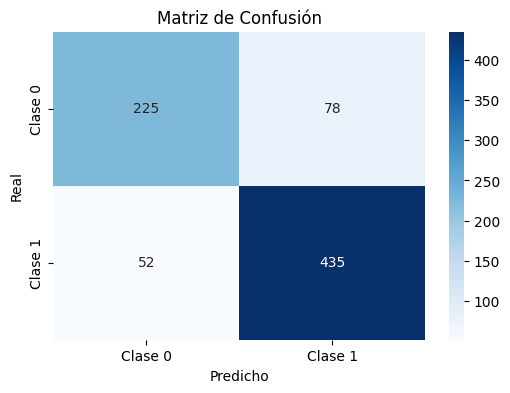

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.81      0.74      0.78       303
     Clase 1       0.85      0.89      0.87       487

    accuracy                           0.84       790
   macro avg       0.83      0.82      0.82       790
weighted avg       0.83      0.84      0.83       790



In [8]:
# 4. Construir y entrenar el modelo final con los mejores HP en todo el conjunto de entrenamiento
# (X_train_reshaped y train_labels)
print("\nEntrenando el modelo final con los mejores hiperparámetros en el conjunto de entrenamiento completo...")

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejor tamaño de filtro: {best_hps.get('size_conv3')}")
print(f"Mejor número de neuronas: {best_hps.get('number_dense')}")
print(f"Mejor optimizador: {best_hps.get('optimizer')}")
print(f"Mejor learning rate: {best_hps.get('learning_rate')}")

final_model = tuner.hypermodel.build(best_hp)
final_model.fit(normed_train_data, train_labels,
                epochs=1000, # Max. épocas, early stopping lo detendrá
                #batch_size=best_hp.get('batch_size'), # Usar el batch_size óptimo
                batch_size=ceil(train_size[0]*0.1),
                callbacks=[early_stopping_callback],
                verbose=1) # Poner en 1 para ver el progreso del entrenamiento final

# 5. Evaluar el modelo final en el conjunto de prueba independiente (normed_test_data)
print("\n==================== ✅ Evaluación del Modelo Final en el Conjunto de Prueba ====================")
#y_pred_probs = final_model.predict(normed_test_data)
#y_pred = (y_pred_probs > 0.5).astype(int)
# Calcular métricas finales
#acc = accuracy_score(test_labels, y_pred)
#prec = precision_score(test_labels, y_pred)
#rec = recall_score(test_labels, y_pred)
#f1 = f1_score(test_labels, y_pred)

test_loss, test_acc, test_prec, test_rec, test_f1 = final_model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))

print(f"Accuracy en Conjunto de Prueba: {test_acc:.4f}")
print(f"Precision en Conjunto de Prueba: {test_prec:.4f}")
print(f"Recall en Conjunto de Prueba: {test_rec:.4f}")
print(f"F1-Score en Conjunto de Prueba: {test_f1:.4f}")


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = final_model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)
# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)
# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))